## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
from keras.regularizers import l1, l2, l1_l2
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.
C:\Users\percy\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\percy\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\percy\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\percy\anaconda3\envs\te

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:

def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
def build_mlp_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
def build_mlp_l1_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}

for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [===

50000/50000 [==============================] - 1s 24us/step - loss: 2.4626 - accuracy: 0.0978 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 1s 24us/step - loss: 2.4626 - accuracy: 0.0984 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 1s 24us/step - loss: 2.4626 - accuracy: 0.0982 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 1s 24us/step - loss: 2.4626 - accuracy: 0.0965 - val_loss: 2.4625 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
____________________________________

50000/50000 [==============================] - 1s 24us/step - loss: 2.8712 - accuracy: 0.6171 - val_loss: 3.1161 - val_accuracy: 0.5268
Epoch 45/50
50000/50000 [==============================] - 1s 24us/step - loss: 2.8397 - accuracy: 0.6164 - val_loss: 3.0421 - val_accuracy: 0.5372
Epoch 46/50
50000/50000 [==============================] - 1s 24us/step - loss: 2.7872 - accuracy: 0.6225 - val_loss: 3.0913 - val_accuracy: 0.5147
Epoch 47/50
50000/50000 [==============================] - 1s 23us/step - loss: 2.7546 - accuracy: 0.6226 - val_loss: 2.9862 - val_accuracy: 0.5371
Epoch 48/50
50000/50000 [==============================] - 1s 24us/step - loss: 2.7119 - accuracy: 0.6253 - val_loss: 2.9929 - val_accuracy: 0.5210
Epoch 49/50
50000/50000 [==============================] - 1s 23us/step - loss: 2.6769 - accuracy: 0.6271 - val_loss: 2.9922 - val_accuracy: 0.5148
Epoch 50/50
50000/50000 [==============================] - 1s 24us/step - loss: 2.6409 - accuracy: 0.6276 - val_loss: 2.9252

Epoch 42/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9634 - accuracy: 0.6616 - val_loss: 1.4692 - val_accuracy: 0.5072
Epoch 43/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9496 - accuracy: 0.6664 - val_loss: 1.4077 - val_accuracy: 0.5175
Epoch 44/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9420 - accuracy: 0.6679 - val_loss: 1.3653 - val_accuracy: 0.5364
Epoch 45/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9238 - accuracy: 0.6769 - val_loss: 1.3628 - val_accuracy: 0.5354
Epoch 46/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9099 - accuracy: 0.6807 - val_loss: 1.5672 - val_accuracy: 0.4916
Epoch 47/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9071 - accuracy: 0.6811 - val_loss: 1.3885 - val_accuracy: 0.5275
Epoch 48/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.8918 - accuracy: 0.6865 - val_

50000/50000 [==============================] - 1s 24us/step - loss: 0.9973 - accuracy: 0.6499 - val_loss: 1.3443 - val_accuracy: 0.5320
Epoch 40/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9833 - accuracy: 0.6544 - val_loss: 1.4174 - val_accuracy: 0.5128
Epoch 41/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9721 - accuracy: 0.6598 - val_loss: 1.3900 - val_accuracy: 0.5198
Epoch 42/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9616 - accuracy: 0.6619 - val_loss: 1.3716 - val_accuracy: 0.5223
Epoch 43/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9432 - accuracy: 0.6686 - val_loss: 1.4416 - val_accuracy: 0.5076
Epoch 44/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9341 - accuracy: 0.6728 - val_loss: 1.3418 - val_accuracy: 0.5328
Epoch 45/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9215 - accuracy: 0.6767 - val_loss: 1.3523

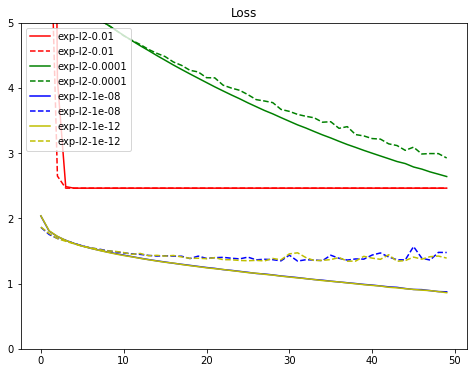

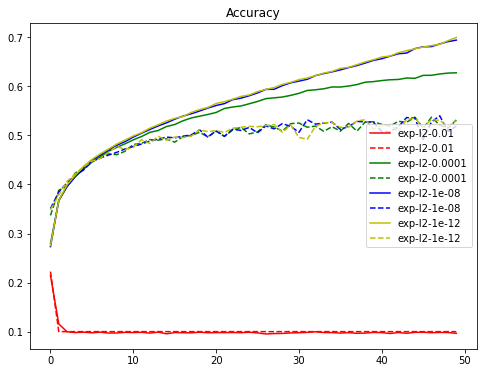

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [9]:
results = {}

for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l2(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 1s 24us/step - loss: 1.6179 - accuracy: 0.5229 - val_loss: 1.6768 - val_accuracy: 0.5000
Epoch 49/50
50000/50000 [==============================] - 1s 24us/step - loss: 1.6151 - accuracy: 0.5248 - val_loss: 1.6899 - val_accuracy: 0.4940
Epoch 50/50
50000/50000 [==============================] - 1s 24us/step - loss: 1.6111 - accuracy: 0.5254 - val_loss: 1.7084 - val_accuracy: 0.4891
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
____________________________________________________

50000/50000 [==============================] - 1s 24us/step - loss: 1.0709 - accuracy: 0.6741 - val_loss: 1.5001 - val_accuracy: 0.5396
Epoch 47/50
50000/50000 [==============================] - 1s 24us/step - loss: 1.0616 - accuracy: 0.6779 - val_loss: 1.5103 - val_accuracy: 0.5303
Epoch 48/50
50000/50000 [==============================] - 1s 24us/step - loss: 1.0485 - accuracy: 0.6810 - val_loss: 1.5527 - val_accuracy: 0.5294
Epoch 49/50
50000/50000 [==============================] - 1s 24us/step - loss: 1.0351 - accuracy: 0.6855 - val_loss: 1.5834 - val_accuracy: 0.5201
Epoch 50/50
50000/50000 [==============================] - 1s 24us/step - loss: 1.0234 - accuracy: 0.6925 - val_loss: 1.5237 - val_accuracy: 0.5318
Experiment with Regulizer = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
____________________

50000/50000 [==============================] - 1s 24us/step - loss: 0.9432 - accuracy: 0.6674 - val_loss: 1.3944 - val_accuracy: 0.5217
Epoch 45/50
50000/50000 [==============================] - 1s 25us/step - loss: 0.9342 - accuracy: 0.6719 - val_loss: 1.4847 - val_accuracy: 0.5077
Epoch 46/50
50000/50000 [==============================] - 1s 25us/step - loss: 0.9203 - accuracy: 0.6754 - val_loss: 1.3523 - val_accuracy: 0.5389
Epoch 47/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9102 - accuracy: 0.6780 - val_loss: 1.4469 - val_accuracy: 0.5133
Epoch 48/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.8950 - accuracy: 0.6830 - val_loss: 1.3783 - val_accuracy: 0.5363
Epoch 49/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.8850 - accuracy: 0.6892 - val_loss: 1.3955 - val_accuracy: 0.5252
Epoch 50/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.8738 - accuracy: 0.6919 - val_loss: 1.4387

Epoch 42/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9595 - accuracy: 0.6619 - val_loss: 1.4236 - val_accuracy: 0.5180
Epoch 43/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9524 - accuracy: 0.6672 - val_loss: 1.3639 - val_accuracy: 0.5327
Epoch 44/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9424 - accuracy: 0.6692 - val_loss: 1.3484 - val_accuracy: 0.5386
Epoch 45/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9272 - accuracy: 0.6750 - val_loss: 1.3546 - val_accuracy: 0.5375
Epoch 46/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9149 - accuracy: 0.6784 - val_loss: 1.3837 - val_accuracy: 0.5299
Epoch 47/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.9066 - accuracy: 0.6822 - val_loss: 1.3636 - val_accuracy: 0.5388
Epoch 48/50
50000/50000 [==============================] - 1s 24us/step - loss: 0.8866 - accuracy: 0.6882 - val_

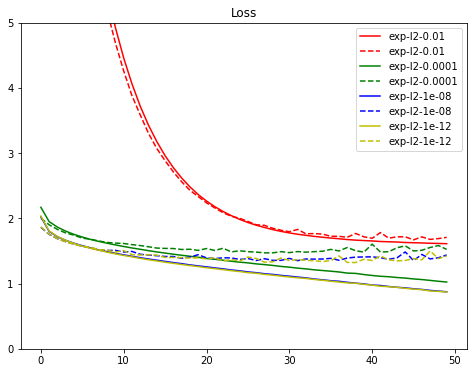

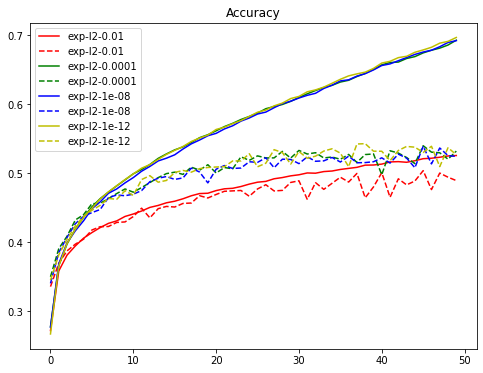

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [11]:
results = {}

for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1_l2(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

Epoch 49/50
50000/50000 [==============================] - 1s 25us/step - loss: 2.4614 - accuracy: 0.0975 - val_loss: 2.4612 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 1s 25us/step - loss: 2.4614 - accuracy: 0.0970 - val_loss: 2.4611 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
________________________________________________________

50000/50000 [==============================] - 1s 24us/step - loss: 1.7680 - accuracy: 0.4774 - val_loss: 1.8057 - val_accuracy: 0.4665
Epoch 47/50
50000/50000 [==============================] - 1s 24us/step - loss: 1.7661 - accuracy: 0.4791 - val_loss: 1.7828 - val_accuracy: 0.4737
Epoch 48/50
50000/50000 [==============================] - 1s 24us/step - loss: 1.7630 - accuracy: 0.4791 - val_loss: 1.7819 - val_accuracy: 0.4715
Epoch 49/50
50000/50000 [==============================] - ETA: 0s - loss: 1.7582 - accuracy: 0.48 - 1s 25us/step - loss: 1.7581 - accuracy: 0.4803 - val_loss: 1.8058 - val_accuracy: 0.4600
Epoch 50/50
50000/50000 [==============================] - 1s 24us/step - loss: 1.7553 - accuracy: 0.4810 - val_loss: 1.8371 - val_accuracy: 0.4527
Experiment with Regulizer = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)   

50000/50000 [==============================] - 1s 26us/step - loss: 1.6378 - accuracy: 0.5156 - val_loss: 1.6858 - val_accuracy: 0.4918
Epoch 44/50
50000/50000 [==============================] - 1s 25us/step - loss: 1.6332 - accuracy: 0.5189 - val_loss: 1.7167 - val_accuracy: 0.4882
Epoch 45/50
50000/50000 [==============================] - 1s 25us/step - loss: 1.6261 - accuracy: 0.5181 - val_loss: 1.6752 - val_accuracy: 0.5023
Epoch 46/50
50000/50000 [==============================] - 1s 25us/step - loss: 1.6238 - accuracy: 0.5228 - val_loss: 1.6914 - val_accuracy: 0.4959
Epoch 47/50
50000/50000 [==============================] - 1s 25us/step - loss: 1.6202 - accuracy: 0.5212 - val_loss: 1.7262 - val_accuracy: 0.4879
Epoch 48/50
50000/50000 [==============================] - 1s 25us/step - loss: 1.6178 - accuracy: 0.5214 - val_loss: 1.6748 - val_accuracy: 0.4992
Epoch 49/50
50000/50000 [==============================] - 1s 25us/step - loss: 1.6119 - accuracy: 0.5233 - val_loss: 1.6598

Epoch 41/50
50000/50000 [==============================] - 1s 25us/step - loss: 1.6559 - accuracy: 0.5122 - val_loss: 1.7121 - val_accuracy: 0.4838
Epoch 42/50
50000/50000 [==============================] - 1s 25us/step - loss: 1.6515 - accuracy: 0.5132 - val_loss: 1.6944 - val_accuracy: 0.4928
Epoch 43/50
50000/50000 [==============================] - 1s 25us/step - loss: 1.6444 - accuracy: 0.5141 - val_loss: 1.6988 - val_accuracy: 0.4888
Epoch 44/50
50000/50000 [==============================] - 1s 25us/step - loss: 1.6386 - accuracy: 0.5171 - val_loss: 1.6788 - val_accuracy: 0.5040
Epoch 45/50
50000/50000 [==============================] - 1s 25us/step - loss: 1.6326 - accuracy: 0.5176 - val_loss: 1.6850 - val_accuracy: 0.4963
Epoch 46/50
50000/50000 [==============================] - 1s 25us/step - loss: 1.6279 - accuracy: 0.5212 - val_loss: 1.7317 - val_accuracy: 0.4770
Epoch 47/50
50000/50000 [==============================] - 1s 25us/step - loss: 1.6238 - accuracy: 0.5224 - val_

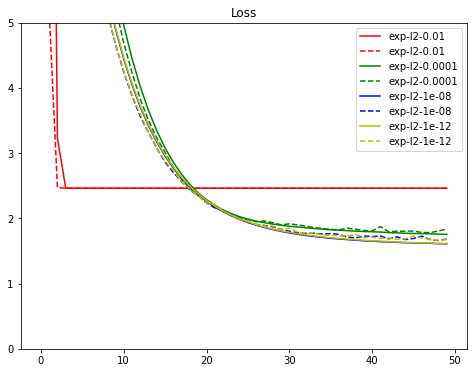

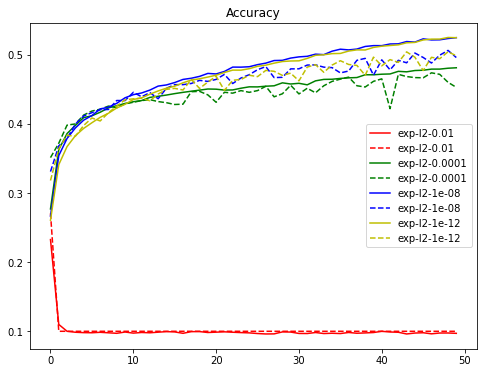

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()